# Logistic Regression vs LogRegCCD on Synthetic Data

In [24]:
import os
if not os.path.exists("./notebooks"):
    %cd ..
    %cd ..

import numpy as np
import matplotlib.pyplot as plt
import json
import pickle
import pandas as pd
from dataclasses import dataclass
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, ConfusionMatrixDisplay
from src.log_reg_ccd import LogRegCCD
from src.data.data_loader import SyntheticDataLoader
from src.data.dataset_interface import DataInterface
import src.measures as measure

## Utils

In [25]:
@dataclass
class ExperimentParams:
    title: str
    n: int
    p: float
    d: int
    g: float
    eps: float = 1e-3
    lam_max: float = 10.0
    lam_count: int = 100
    k_fold: int = 10

In [26]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [27]:
def test_model(model, X, y, save_path=None, ccd=True):
    results = {}

    y_pred = model.predict(X)
    if ccd:
        y_pred_proba = model.predict_proba(X)
        results['coefficients'] = model.best_beta
    else:
        y_pred_proba = model.predict_proba(X)[:,1]
        results['coefficients'] = np.concatenate((model.intercept_, model.coef_[0]))

    results['accuracy'] = accuracy_score(y, y_pred)
    results['classification_report'] = classification_report(y, y_pred)
    results['confusion_matrix'] = confusion_matrix(y, y_pred)
    results['auc_roc'] = aucroc(y, y_pred_proba)
    results['balanced_accuracy'] = ba(y, y_pred)

    print(f"\nCoefficients: {results['coefficients']}")
    print(f"\n{color.CYAN}{color.UNDERLINE}{aucroc}{color.END}: {results['auc_roc']}")
    print(f"\n{color.CYAN}{color.UNDERLINE}{ba}{color.END}: {results['balanced_accuracy']}")
    print(f"\nAccuracy: {results['accuracy']:.4f}")
    print(f"\nClassification Report:\n{results['classification_report']}")
    print(f"\nConfusion Matrix:")
    plt.figure()
    disp = ConfusionMatrixDisplay(confusion_matrix=results['confusion_matrix'])
    disp.plot()

    if save_path:
        with open(save_path, 'w') as f:
            f.write("="*50 + "\n")
            f.write("MODEL EVALUATION RESULTS\n")
            f.write("="*50 + "\n\n")
            
            f.write("COEFFICIENTS:\n")
            f.write(str(results['coefficients']) + "\n\n")
            
            if 'auc_roc' in results:
                f.write(f"AUC-ROC SCORE: {results['auc_roc']:.4f}\n\n")
            
            if 'balanced_accuracy' in results:
                f.write(f"BALANCED ACCURACY: {results['balanced_accuracy']:.4f}\n\n")
            
            f.write(f"ACCURACY: {results['accuracy']:.4f}\n\n")
            
            f.write("CLASSIFICATION REPORT:\n")
            f.write(results['classification_report'] + "\n\n")
            
            f.write("CONFUSION MATRIX:\n")
            np.savetxt(f, results['confusion_matrix'], fmt='%d')
            f.write("\n")
            
            f.write("="*50 + "\n")
        
        plot_path = str(save_path).replace('.txt', '_confusion_matrix.pdf')
        plt.savefig(plot_path, format='pdf', bbox_inches='tight')
    
    plt.show()

## Experiments params

In [28]:
experiments = [
    
    ExperimentParams(title='Default', n=1000, p=0.5, d=10, g=0.1),

    ExperimentParams(title='Few samples', n=100, p=0.5, d=10, g=0.1),
    ExperimentParams(title='Lots of samples', n=10000, p=0.5, d=10, g=0.1),

    ExperimentParams(title='Slightly imbalanced', n=1000, p=0.3, d=10, g=0.1),
    ExperimentParams(title='Highly impalanced', n=1000, p=0.1, d=10, g=0.1),

    ExperimentParams(title='Few features', n=1000, p=0.5, d=5, g=0.1),
    ExperimentParams(title='Lots of features', n=1000, p=0.5, d=100, g=0.1),

    ExperimentParams(title='Moderate correlation', n=1000, p=0.5, d=10, g=0.5),
    ExperimentParams(title='Strong correlation', n=1000, p=0.5, d=10, g=0.9),

]

## Experiment choice

In [29]:
random_seed = 42
chosen_experiment = 'Default'
results_main_dir = 'synthetic_data'

In [30]:
results_dir = os.path.join('results', os.path.join(results_main_dir, chosen_experiment))
os.makedirs(results_dir, exist_ok=True)

experiment = next(exp for exp in experiments if exp.title == chosen_experiment)
aucroc = measure.AUCROC()
ba = measure.BalancedAccuracy()

In [31]:
# def ex(experiment):

#     results_dir = os.path.join('results', os.path.join(results_main_dir, experiment.title))
#     os.makedirs(results_dir, exist_ok=True)

#     di = DataInterface(SyntheticDataLoader(experiment.p, experiment.n, experiment.d, experiment.g, random_seed))
#     di.split_data(val_size=0.2, test_size=0.3)
#     data = di.get_data()
#     X_train, y_train = data['train_data'], data['train_labels']
#     X_valid, y_valid = data['val_data'], data['val_labels']
#     X_test, y_test = data['test_data'], data['test_labels']

#     scaler = StandardScaler()
#     scaler.fit(X_train)
#     X_train = scaler.transform(X_train)
#     X_test = scaler.transform(X_test)

#     model = LogisticRegression(penalty=None)
#     model.fit(X_train, y_train)
#     test_model(model, X_test, y_test, os.path.join(results_dir, 'sklearn_metrics.txt'), False)

#     model_ccd = LogRegCCD(verbose=False)
#     model_ccd.fit(X_train, y_train, experiment.eps, experiment.lam_max, experiment.lam_count, experiment.k_fold)
#     test_model(model_ccd, X_test, y_test, os.path.join(results_dir, 'logregccd_metrics.txt'))

#     fig = model_ccd.plot(X_valid, y_valid, measure=aucroc)
#     fig.savefig(os.path.join(results_dir, 'logregccd_aucroc.pdf'), format='pdf', bbox_inches='tight')
#     plt.close(fig)
#     model_ccd.validate(X_valid, y_valid, measure=aucroc)
#     test_model(model_ccd, X_test, y_test, os.path.join(results_dir, 'logregccd_aucroc_metrics.txt'))

#     fig = model_ccd.plot(X_valid, y_valid, measure=ba)
#     fig.savefig(os.path.join(results_dir, 'logregccd_ba.pdf'), format='pdf', bbox_inches='tight')
#     plt.close(fig)
#     model_ccd.validate(X_valid, y_valid, measure=ba)
#     test_model(model_ccd, X_test, y_test, os.path.join(results_dir, 'logregccd_ba_metrics.txt'))

# for idx, exp in enumerate(experiments):
#     ex(exp)
    

## Data loading

In [32]:
di = DataInterface(SyntheticDataLoader(experiment.p, experiment.n, experiment.d, experiment.g, random_seed))
di.split_data(val_size=0.2, test_size=0.3)
data = di.get_data()
X_train, y_train = data['train_data'], data['train_labels']
X_valid, y_valid = data['val_data'], data['val_labels']
X_test, y_test = data['test_data'], data['test_labels']

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## LogisticRegression


Coefficients: [0.04763053 1.31354926 0.63858186 0.05971532 0.34383042 0.29294876
 0.14197142 0.33835913 0.08775935 0.22523133 0.13661218]

AUC ROC: 0.7958175750834261

Balanced accuracy: 0.7382647385984427

Accuracy: 0.7367

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.69      0.73       155
           1       0.70      0.79      0.74       145

    accuracy                           0.74       300
   macro avg       0.74      0.74      0.74       300
weighted avg       0.74      0.74      0.74       300


Confusion Matrix:


<Figure size 640x480 with 0 Axes>

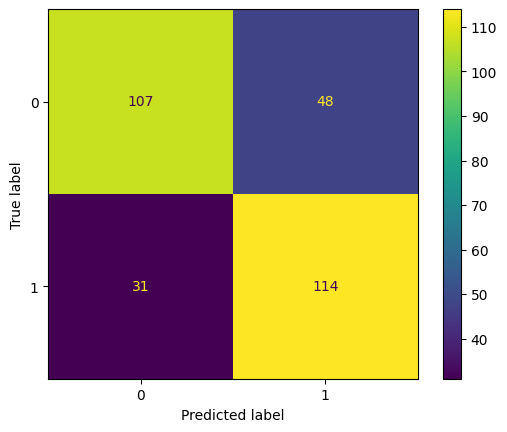

In [33]:
model = LogisticRegression(penalty=None)
model.fit(X_train, y_train)
test_model(model, X_test, y_test, os.path.join(results_dir, 'sklearn_metrics.txt'), False)

## LogRegCCD


Coefficients: [0.03309715 1.15530674 0.53586764 0.01442593 0.26084228 0.21664665
 0.08915    0.25685184 0.01816719 0.14353119 0.06329095]

AUC ROC: 0.7979532814238042

Balanced accuracy: 0.7348164627363738

Accuracy: 0.7333

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.69      0.73       155
           1       0.70      0.78      0.74       145

    accuracy                           0.73       300
   macro avg       0.74      0.73      0.73       300
weighted avg       0.74      0.73      0.73       300


Confusion Matrix:


<Figure size 640x480 with 0 Axes>

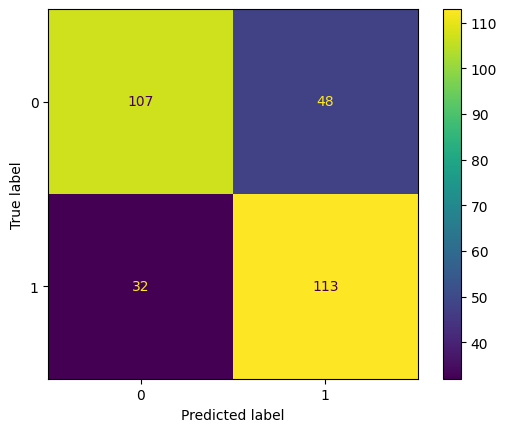

In [34]:
model_ccd = LogRegCCD(verbose=False)
model_ccd.fit(X_train, y_train, experiment.eps, experiment.lam_max, experiment.lam_count, experiment.k_fold)
test_model(model_ccd, X_test, y_test, os.path.join(results_dir, 'logregccd_metrics.txt'))

### AUC ROC

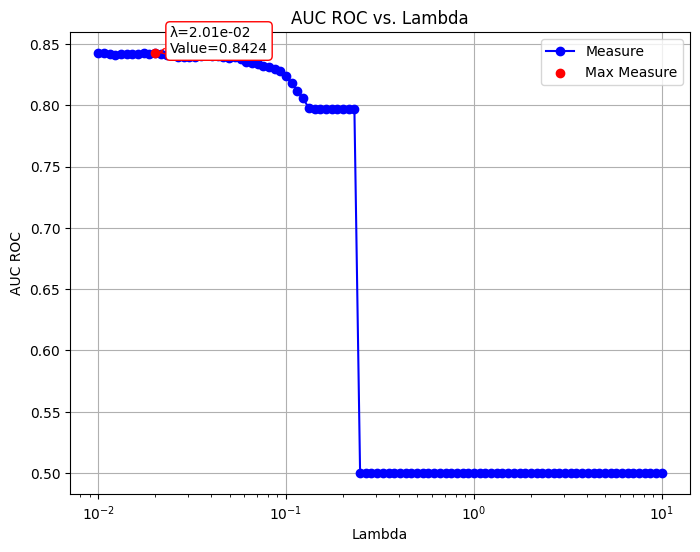


Coefficients: [0.0265547  1.07827536 0.48434236 0.         0.21617361 0.17613676
 0.06033601 0.21058108 0.         0.09924649 0.02375587]

AUC ROC: 0.7974638487208008

Balanced accuracy: 0.7380422691879867

Accuracy: 0.7367

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.70      0.73       155
           1       0.71      0.78      0.74       145

    accuracy                           0.74       300
   macro avg       0.74      0.74      0.74       300
weighted avg       0.74      0.74      0.74       300


Confusion Matrix:


<Figure size 640x480 with 0 Axes>

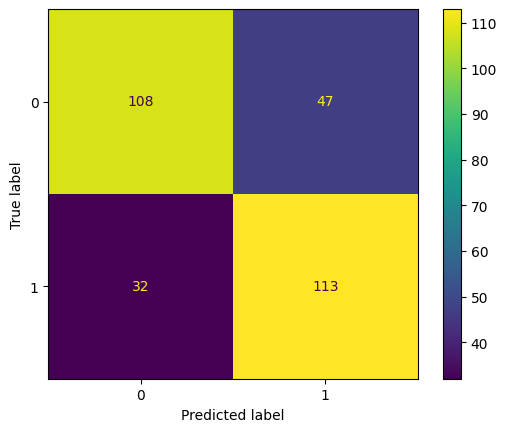

In [35]:
fig = model_ccd.plot(X_valid, y_valid, measure=aucroc)
fig.savefig(os.path.join(results_dir, 'logregccd_aucroc.pdf'), format='pdf', bbox_inches='tight')
plt.show(fig)
model_ccd.validate(X_valid, y_valid, measure=aucroc)
test_model(model_ccd, X_test, y_test, os.path.join(results_dir, 'logregccd_aucroc_metrics.txt'))

### Balanced Accuracy

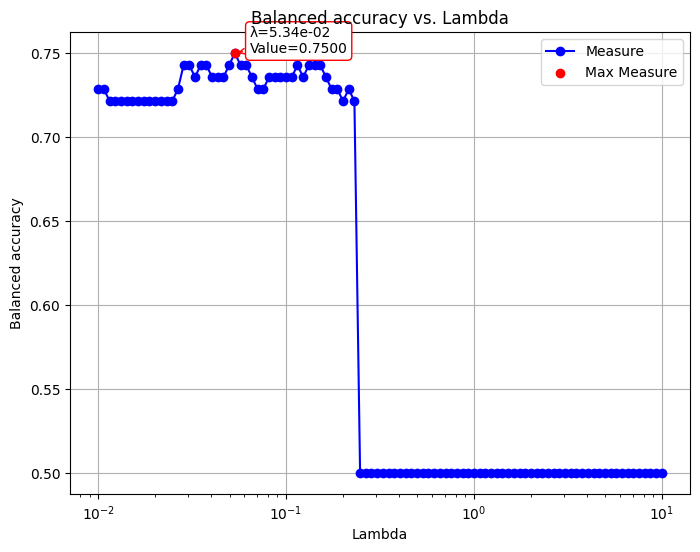


Coefficients: [0.01399746 0.84319779 0.31656928 0.         0.06264556 0.03099713
 0.         0.02487077 0.         0.         0.        ]

AUC ROC: 0.7858954393770856

Balanced accuracy: 0.7150166852057842

Accuracy: 0.7133

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.66      0.71       155
           1       0.68      0.77      0.72       145

    accuracy                           0.71       300
   macro avg       0.72      0.72      0.71       300
weighted avg       0.72      0.71      0.71       300


Confusion Matrix:


<Figure size 640x480 with 0 Axes>

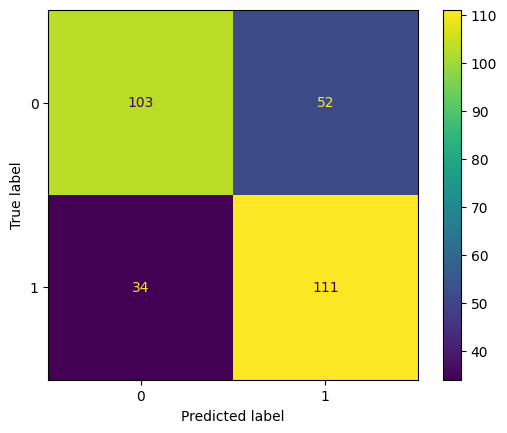

In [36]:
fig = model_ccd.plot(X_valid, y_valid, measure=ba)
fig.savefig(os.path.join(results_dir, 'logregccd_ba.pdf'), format='pdf', bbox_inches='tight')
plt.show(fig)
model_ccd.validate(X_valid, y_valid, measure=ba)
test_model(model_ccd, X_test, y_test, os.path.join(results_dir, 'logregccd_ba_metrics.txt'))